# EPiC-FM for JetClass data

### Load and visualize JetClass data

In [2]:
from utils import Configs
from data import JetsClassData

config = Configs('configs.yaml')
jets = JetsClassData(config=config.data)

In [2]:
jets.source.particles.shape, jets.target.particles.shape

(torch.Size([100000, 128, 3]), torch.Size([100000, 128, 3]))

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3, figsize=(7,2))

jets.source.histplot('pt_rel', ax=ax[0], log_scale=(False,True), stat='density', label='source')
jets.target.histplot('pt_rel', ax=ax[0], log_scale=(False,True), stat='density', label='target')
jets.source.histplot('eta_rel', ax=ax[1], stat='density')
jets.target.histplot('eta_rel', ax=ax[1], stat='density')
jets.source.histplot('phi_rel', ax=ax[2], label='source', stat='density')
jets.target.histplot('phi_rel', ax=ax[2], label='target', stat='density')
ax[0].legend(fontsize=6)
plt.tight_layout()
plt.show()

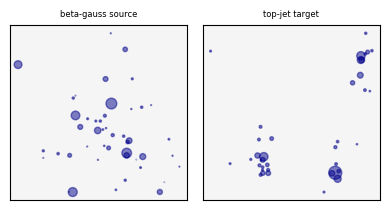

In [2]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(1,2, figsize=(4, 2.2))
jets.source.display_cloud(idx=10,  scale_marker=20.0, ax=ax[0])
jets.target.display_cloud(idx=10,  scale_marker=20.0, ax=ax[1])
ax[0].set_title('beta-gauss source', fontsize=6)
ax[1].set_title('top-jet target', fontsize=6)
plt.tight_layout()
plt.show()

For the source data (noise) we sample a particle mask tensor from the jet multiplicity distribution of the target data:

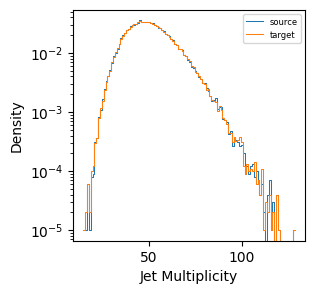

In [4]:
import seaborn as sns

fig,ax = plt.subplots(1,1,figsize=(3,3))
sns.histplot(jets.source.multiplicity, element="step", fill=False, discrete=True, lw=0.75, stat='density', log_scale=(False, True),  ax=ax, label='source')
sns.histplot(jets.target.multiplicity, element="step", fill=False, discrete=True, lw=0.75, stat='density', log_scale=(False, True),  ax=ax, label='target')
ax.legend(fontsize=6)
ax.set_xlabel('Jet Multiplicity')
plt.show()

### EPiC
Permutation equivariant architecture for point clouds

TODO: [Novel idea] Replace Linear layers with KAN layers. 

In [3]:
import torch
from torch import nn
from torch.nn import functional as F
import torch.nn.utils.weight_norm as weight_norm

from utils import SinusoidalPositionalEncoding

class EPiC(nn.Module):
    ''' Model wrapper for EPiC Network

        Forward pass:
            - t: time input of shape (b, 1)
            - x: particle features of shape (b, n, dim_features)
            - context: context features of shape (b, dim_context)
            - mask: binary mask of shape (b, n, 1) indicating valid particles (1) or masked particles (0)
        '''

    def __init__(self, config):
        super().__init__()

        self.device = config.train.device

        #...data dimensions:
        dim_features = config.data.dim.features
        dim_context = config.data.dim.context

        #...embedding dimensions:
        dim_time_emb = config.model.dim.embed.time
        dim_features_emb = config.model.dim.embed.features if config.model.dim.embed.features else dim_features
        dim_context_emb = config.model.dim.embed.context if config.model.dim.embed.context else dim_context

        #...components:
        self.embedding = InputEmbeddings(config)
        self.epic = EPiCNetwork(dim_input=dim_time_emb + dim_features_emb,
                                dim_output=dim_features,
                                dim_context=dim_time_emb + dim_context_emb,
                                num_blocks=config.model.num_blocks,
                                dim_hidden_local=config.model.dim.hidden.local,
                                dim_hidden_global=config.model.dim.hidden.glob,
                                use_skip_connection=config.model.skip_connection)
                                                
    def forward(self, t, x, context=None, mask=None):

        t = t.to(self.device) 
        x = x.to(self.device) 
        context = context.to(self.device) if isinstance(context, torch.Tensor) else None 
        mask = mask.to(self.device)

        x_local_emb, context_emb = self.embedding(t, x, context, mask)
        h = self.epic(x_local_emb, context_emb, mask)
        
        return h    


class EPiCNetwork(nn.Module):
    def __init__(self, 
                 dim_input,
                 dim_output=3,
                 dim_context=0,
                 num_blocks=6,
                 dim_hidden_local=128,
                 dim_hidden_global=10,
                 use_skip_connection=False):
        
        super().__init__()
        
        #...model params:
        self.num_blocks = num_blocks
        self.use_skip_connection = use_skip_connection

        #...components:
        self.epic_proj = EPiC_Projection(dim_local=dim_input,
                                         dim_global=dim_context,
                                         dim_hidden_local=dim_hidden_local,
                                         dim_hidden_global=dim_hidden_global,
                                         pooling_fn=self.meansum_pool)

        self.epic_layers = nn.ModuleList()

        for _ in range(self.num_blocks):
            self.epic_layers.append(EPiC_layer(dim_local=dim_hidden_local, 
                                               dim_global=dim_hidden_global, 
                                               dim_hidden=dim_hidden_local, 
                                               dim_context=dim_context,
                                               pooling_fn=self.meansum_pool))
            
        #...output layer:

        self.output_layer = weight_norm(nn.Linear(dim_hidden_local, dim_output))

    def meansum_pool(self, mask, x_local, *x_global):
        ''' masked pooling local features with mean and sum
            the concat with global features
        '''
        x_sum = (x_local * mask).sum(1, keepdim=False)
        x_mean = x_sum / mask.sum(1, keepdim=False)
        x_pool = torch.cat([x_mean, x_sum, *x_global], 1) 
        return x_pool
                       
    def forward(self, x_local, context=None, mask=None):

        #...Projection network:
        x_local, x_global = self.epic_proj(x_local, context, mask)
        x_local_skip = x_local.clone() if self.use_skip_connection else 0
        x_global_skip = x_global.clone() if self.use_skip_connection else 0

        #...EPiC layers:
        for i in range(self.num_blocks):
            x_local, x_global = self.epic_layers[i](x_local, x_global, context, mask)   
            x_local += x_local_skip
            x_global += x_global_skip 
    
        #...output layer:
        h = self.output_layer(x_local)

        return h * mask    #[batch, points, feats]

class EPiC_Projection(nn.Module):
    def __init__(self, 
                 dim_local, 
                 dim_global, 
                 dim_hidden_local, 
                 dim_hidden_global,
                 pooling_fn):
        
        super(EPiC_Projection, self).__init__()

        self.pooling_fn = pooling_fn
        self.local_0 = weight_norm(nn.Linear(dim_local, dim_hidden_local))  
        self.global_0 = weight_norm(nn.Linear(2 * dim_hidden_local + dim_global, dim_hidden_local)) # local 2 global 
        self.global_1 = weight_norm(nn.Linear(dim_hidden_local, dim_hidden_local))
        self.global_2 = weight_norm(nn.Linear(dim_hidden_local, dim_hidden_global))

    def forward(self, x_local, x_global, mask):
        '''Input shapes: 
           - x_local: (b, num_points, dim_local)
           - x_global = [b, dim_global]
          Out shapes:
           - x_local: (b, num_points, dim_hidden_local)
           - x_global = [b, dim_hidden_global]
        '''
        x_local = F.leaky_relu(self.local_0(x_local)) 
        x_global = self.pooling_fn(mask, x_local, x_global)
        x_global = F.leaky_relu(self.global_0(x_global))      
        x_global = F.leaky_relu(self.global_1(x_global))
        x_global = F.leaky_relu(self.global_2(x_global))   
        return x_local * mask, x_global

class EPiC_layer(nn.Module):
    # based on https://github.com/uhh-pd-ml/EPiC-GAN/blob/main/models.py
    def __init__(self, 
                 dim_local, 
                 dim_global, 
                 dim_hidden, 
                 dim_context,
                 pooling_fn):
        
        super(EPiC_layer, self).__init__()
        
        self.pooling_fn = pooling_fn
        self.fc_global1 = weight_norm(nn.Linear(int(2*dim_local) + dim_global + dim_context, dim_hidden)) 
        self.fc_global2 = weight_norm(nn.Linear(dim_hidden, dim_global)) 
        self.fc_local1 = weight_norm(nn.Linear(dim_local + dim_global + dim_context, dim_hidden))
        self.fc_local2 = weight_norm(nn.Linear(dim_hidden, dim_local))
    
    def forward(self, x_local, x_global, context, mask):
        '''Input/Output shapes: 
           - x_local: (b, num_points, dim_local)
           - x_global = [b, dim_global]
           - context = [b, dim_context]
        '''
        num_points, dim_global, dim_context = x_local.size(1), x_global.size(1), context.size(1)
        x_pooledCATglobal = self.pooling_fn(mask, x_local, x_global, context)
        x_global1 = F.leaky_relu(self.fc_global1(x_pooledCATglobal))   
        x_global = F.leaky_relu(self.fc_global2(x_global1) + x_global) # with residual connection before AF
        x_global2local = x_global.view(-1, 1, dim_global).repeat(1, num_points, 1) # first add dimension, than expand it
        x_context2local = context.view(-1, 1, dim_context).repeat(1, num_points, 1)  
        x_localCATglobal = torch.cat([x_local, x_global2local, x_context2local], 2)
        x_local1 = F.leaky_relu(self.fc_local1(x_localCATglobal))  
        x_local = F.leaky_relu(self.fc_local2(x_local1) + x_local)

        return x_local * mask, x_global


class InputEmbeddings(nn.Module):
    def __init__(self, config):

        super(InputEmbeddings, self).__init__()

        #...Dimensions:
        dim_features = config.data.dim.features  
        dim_context = config.data.dim.context

        #...Embedding dimensions:
        dim_time_emb = config.model.dim.embed.time
        dim_features_emb = config.model.dim.embed.features if config.model.dim.embed.features else dim_features
        dim_context_emb = config.model.dim.embed.context if config.model.dim.embed.context else dim_context

        #...Embedding types:
        embed_type_time = config.model.embed_type.time
        embed_type_features = config.model.embed_type.features
        embed_type_context = config.model.embed_type.context

        #...Time embeddings:
        if embed_type_time == 'SinusoidalPositionalEncoding':  self.time_embedding = SinusoidalPositionalEncoding(dim_time_emb, max_period=10000)
        # elif embed_type_time == 'KANLinear':  self.time_embedding = KANLinear(1, dim_time_emb)
        elif embed_type_time == 'Linear': self.time_embedding = nn.Linear(1, dim_time_emb)  
        else: NotImplementedError('Time embedding not implemented, choose from `SinusoidalPositionalEncoding`, `KANLinear` or `Linear`') 

        #...Feature embeddings:
        if embed_type_features == 'Linear':  self.feature_embedding = nn.Linear(dim_features, dim_features_emb) 
        # elif embed_type_features == 'KANLinear':  self.feature_embedding = KANLinear(dim_features, dim_features_emb)
        elif embed_type_features is None:  self.feature_embedding = nn.Identity() 
        else: NotImplementedError('Features embedding not implemented, choose from `KANLinear`, `Linear` or None') 

        #...Context embeddings:
        if dim_context:
            if embed_type_context == 'Linear':  self.context_embedding = nn.Linear(dim_context, dim_context_emb)
            # elif embed_type_context == 'KANLinear': self.context_embedding = KANLinear(dim_context, dim_context_emb)
            elif embed_type_context is None:  self.context_embedding = nn.Identity()
            else: NotImplementedError('Context embedding not implemented, use `KANLinear`, `Linear` or None')


    def forward(self, t, x, context=None, mask=None):

        t_emb = self.time_embedding(t.squeeze(-1)) 
        t_context_emb = t_emb.clone()    
        x_emb = self.feature_embedding(x)

        if x.ndim == 3: 
            t_emb = t_emb.unsqueeze(1).repeat(1, x.shape[1], 1)   # (b, dim_time_emb) -> (b, n, dim_time_emb)
         
        features = [t_emb, x_emb] 
        context = [t_context_emb] 

        if hasattr(self, 'embedding_context_continuous'):
            emb = self.embedding_context_continuous(context)
            context.append(emb)

        features = torch.cat(features, dim=-1)    # (b, n, dim_feature_emb + dim_time_emb)
        context = torch.cat(context, dim=-1)      # (b, dim_context_emb + dim_time_emb)

        return features * mask, context

In [4]:
EPiC(config)

EPiC(
  (embedding): InputEmbeddings(
    (time_embedding): SinusoidalPositionalEncoding()
    (feature_embedding): Linear(in_features=3, out_features=16, bias=True)
  )
  (epic): EPiCNetwork(
    (epic_proj): EPiC_Projection(
      (local_0): Linear(in_features=32, out_features=128, bias=True)
      (global_0): Linear(in_features=272, out_features=128, bias=True)
      (global_1): Linear(in_features=128, out_features=128, bias=True)
      (global_2): Linear(in_features=128, out_features=16, bias=True)
    )
    (epic_layers): ModuleList(
      (0): EPiC_layer(
        (fc_global1): Linear(in_features=288, out_features=128, bias=True)
        (fc_global2): Linear(in_features=128, out_features=16, bias=True)
        (fc_local1): Linear(in_features=160, out_features=128, bias=True)
        (fc_local2): Linear(in_features=128, out_features=128, bias=True)
      )
      (1): EPiC_layer(
        (fc_global1): Linear(in_features=288, out_features=128, bias=True)
        (fc_global2): Linear(

### EPiC flow-matching

TODO: [Novel idea] implement flow-matching using beta distirbutions for the paths. This would guarantee that the relative momenta are always in the [0,1] interval. 

In [5]:
import torch 
from dataclasses import dataclass
from utils import OTPlanSampler

class ConditionalFlowMatching:
	''' Conditional Flow Matching base class
	'''
	def __init__(self, config: dataclass):
		self.config = config.dynamics
		self.loss_fn = torch.nn.MSELoss(reduction='sum')

	def sample_coupling(self, batch):
		""" source-target coupling (x_0, x1) ~ pi(x_0, x_1)
		"""		
		self.x0 = batch.source
		self.x1 = batch.target
		self.context = batch.context if hasattr(batch, 'context') else None
		self.mask = batch.mask if hasattr(batch, 'mask') else torch.ones_like(self.x0[..., 0]).unsqueeze(-1)

	def sample_time(self):
		""" sample time: t ~ U[0,1]
		"""
		t = torch.rand(self.x1.shape[0], device=self.x1.device).type_as(self.x1)
		self.t = self.reshape_time(t, self.x1)

	def sample_bridge(self):
		""" sample Gaussian bridge connecting source to target samples: x_t ~ p_t(x|x_0, x_1)
		"""
		mean = self.t * self.x1 + (1. - self.t) * self.x0
		std = self.config.sigma
		self.xt = mean + std * torch.randn_like(mean)

	def get_drift(self):
		""" conditional drift u_t(x|x_0,x_1)
		"""
		self.drift = self.x1 - self.x0

	def loss(self, model, batch):
		""" conditional flow-mathcing MSE loss
		"""
		self.sample_coupling(batch)
		self.sample_time() 
		self.sample_bridge()
		self.get_drift()
		
		vt = model(t=self.t, 
			 	   x=self.xt, 
				   context=self.context, 
				   mask=self.mask)
		
		ut = self.drift * self.mask
		ut = ut.to(vt.device)
		loss = self.loss_fn(vt, ut)
		return loss / self.mask.sum()

	def reshape_time(self, t, x):
		if isinstance(t, (float, int)): return t
		else: return t.reshape(-1, *([1] * (x.dim() - 1)))


class OTCFM(ConditionalFlowMatching):
	def sample_coupling(self, batch):
		OT = OTPlanSampler()	
		self.x0, self.x1 = OT.sample_plan(batch.source_continuous, batch.target_continuous)	
		self.context = batch.context if hasattr(batch, 'context') else None
		self.mask = batch.mask if hasattr(batch, 'mask') else torch.ones_like(self.x0[..., 0]).unsqueeze(-1)


class SBCFM(ConditionalFlowMatching):
	def sample_coupling(self, batch):
		regulator = 2 * self.config.sigma**2
		SB = OTPlanSampler(reg=regulator)
		self.x0, self.x1 = SB.sample_plan(batch.source_continuous, batch.target_continuous)	
		self.context = batch.context if hasattr(batch, 'context') else None
		self.mask = batch.mask if hasattr(batch, 'mask') else torch.ones_like(self.x0[..., 0]).unsqueeze(-1)

	def sample_bridge(self):
		self.mean = self.t * self.x1 + (1 - self.t) * self.x0
		std = self.config.sigma * torch.sqrt(self.t * (1 - self.t))
		self.xt = self.mean + std * torch.randn_like(self.mean)
		
	def get_drift(self):
		""" conditional drift u_t(x|x_0,x_1)
		"""
		A = (1 - 2 * self.t) / ( self.t * (1 - self.t))
		B = self.t**2 / ( self.t * (1 - self.t))
		C = -1 * (1 - self.t)**2 / ( self.t * (1 - self.t))

		self.drift = A * self.xt + B * self.x1 + C * self.x0


class BetaFlowMatching(ConditionalFlowMatching):
	def sample_coupling(self, batch):
		OT = OTPlanSampler()	
		self.x0, self.x1 = OT.sample_plan(batch.source_continuous, batch.target_continuous)	
		self.context = batch.context if hasattr(batch, 'context') else None
		self.mask = batch.mask if hasattr(batch, 'mask') else torch.ones_like(self.x0[..., 0]).unsqueeze(-1)

	def sample_bridge(self):
			""" sample approximate Beta bridge for energies and gaussian bridge for positions.
			"""
			std = self.config.sigma

			z0 = self.x0[..., 0]
			z1 = self.x1[..., 0]
			r0 = self.x0[..., 1:]
			r1 = self.x1[..., 1:]

			r_mean = self.t * r1 + (1. - self.t) * r0
			rt = r_mean + std * torch.randn_like(r_mean)

			z_mean = self.t * z1 + (1. - self.t) * z0
			zt = z_mean + std * torch.randn_like(z_mean)

			self.xt = torch.cat([zt.unsqueeze(-1), rt], dim=-1)


In [ ]:
from trainers import CFMTrainer

epic = EPiC(config)
cfm = ConditionalFlowMatching(config)

epic_fm = CFMTrainer(config=config, 
                     dynamics=cfm, 
                     drift_model=epic, 
                     dataclass=jets)
epic_fm.train()


### Generation pipeline

In [7]:
import torch
import torch.nn as nn
from dataclasses import dataclass

class Pipeline:
    def __init__(self, 
                 config: dataclass,
                 trained_model: nn.Module,
                 best_epoch_model: bool=True
                 ):

        self.config = config
        self.model = trained_model.best_epoch_model if best_epoch_model else trained_model.last_epoch_model
        self.time_steps = torch.linspace(0.0, 1.0 - config.pipeline.time_eps, config.pipeline.num_timesteps)

    @torch.no_grad()
    def generate_samples(self, **source):
        
        if self.config.pipeline.method == 'EulerSolver':
            solver = EulerSolver(config=self.config, model=self.model)
            paths = solver.simulate(time_steps=self.time_steps, **source)
            self.paths = paths.detach().cpu()

        elif self.config.pipeline.method == 'RK4Solver':
            solver = RK4Solver(config=self.config, model=self.model)
            paths = solver.simulate(time_steps=self.time_steps, **source)
            self.paths = paths.detach().cpu()
        else:
            raise ValueError('Unknown pipeline method.')


class EulerSolver:
    ''' Euler ODE solver for continuous states
    '''
    def __init__(self, config, model):
        self.device = config.train.device
        self.model = model

    def simulate(self, 
                 time_steps, 
                 source, 
                 context=None, 
                 mask=None):
        
        x = source.to(self.device)
        time_steps = time_steps.to(self.device)
        context = context.to(self.device) if context is not None else None
        mask = mask.to(self.device) if mask is not None else None
        
        delta_t = (time_steps[-1] - time_steps[0]) / (len(time_steps) - 1)
        paths = [x.clone()]

        for time in time_steps[1:]:
            time = torch.full((x.size(0), 1), time.item(), device=self.device)
            drift = self.model(t=time, 
                                x=x, 
                                context=context, 
                                mask=mask).to(self.device)
            x += delta_t * drift
            x *= mask
            paths.append(x.clone())
        
        paths = torch.stack(paths)

        return paths


class RK4Solver:
    ''' TODO Runge Kuta 4th order ODE solver for continuous states
    '''
    def __init__(self, config, model):
        self.device = config.train.device
        self.model = model
        
    def simulate(self, 
                 time_steps, 
                 source, 
                 context=None, 
                 mask=None):
        pass

In [8]:
num_gen_jets = 3000
test = JetsClassData(config=config.data)
input_source = test.source.particles[:num_gen_jets]
mask = test.source.mask[:num_gen_jets]

pipeline = Pipeline(config=config, trained_model=epic_fm)
pipeline.generate_samples(source=input_source, mask=mask)


### Plots

In [9]:
import torch
from data import ParticleClouds

generated = torch.cat([pipeline.paths[-1], test.source.mask[:num_gen_jets]], dim=-1)
jets_generated = ParticleClouds(generated) 

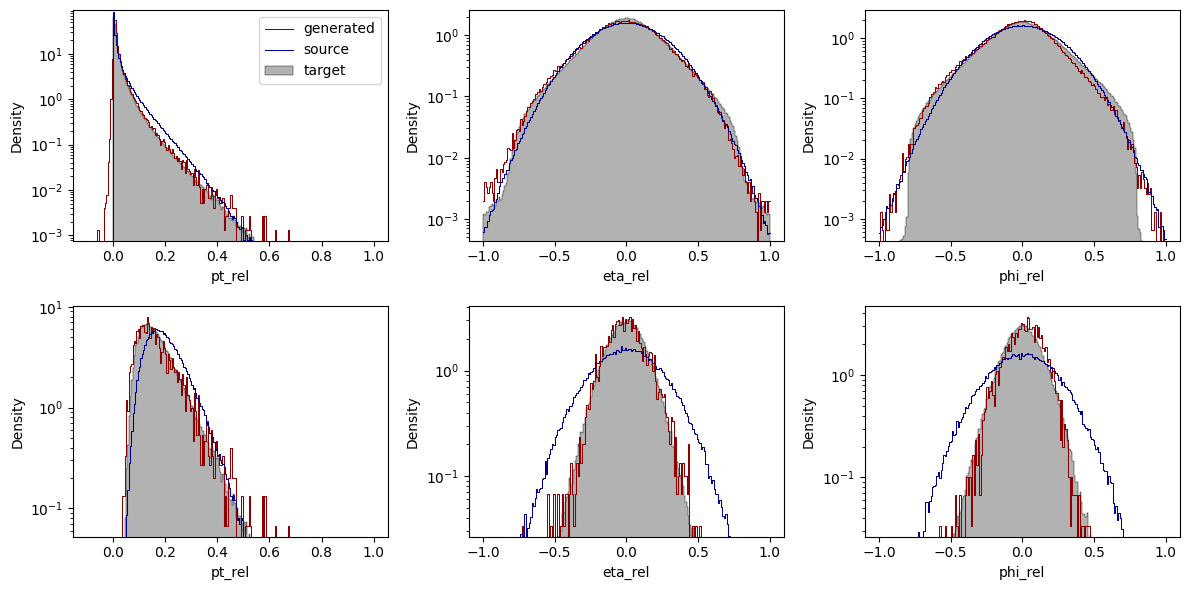

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 3, figsize=(12,6))

binrange_0, binwidth_0 = (-0.1, 1), 0.005
binrange_1, binwidth_1 = (-1, 1), 0.01
binrange_2, binwidth_2 = (-1, 1), 0.01

#...all particle constituents

jets_generated.histplot('pt_rel', binrange=binrange_0, binwidth=binwidth_0, ax=ax[0,0], color='darkred', log_scale=(False, True), fill=False, stat='density',lw=0.75, label='generated')
test.source.histplot('pt_rel', binrange=binrange_0, binwidth=binwidth_0, ax=ax[0,0], log_scale=(False, True),  color='darkblue',  fill=False,  stat='density',lw=0.75, label='source')
jets.target.histplot('pt_rel', binrange=binrange_0, binwidth=binwidth_0, ax=ax[0,0], log_scale=(False, True),  color='k', stat='density', alpha=0.3, lw=0.3, label='target')

jets_generated.histplot('eta_rel', binrange=binrange_1, binwidth=binwidth_1, ax=ax[0,1], log_scale=(False, True), color='darkred', fill=False, stat='density', lw=0.75, label='generated')
test.source.histplot('eta_rel', binrange=binrange_1, binwidth=binwidth_1,  ax=ax[0,1], log_scale=(False, True),  color='darkblue',  fill=False,  stat='density',lw=0.75, label='source')
jets.target.histplot('eta_rel', binrange=binrange_1, binwidth=binwidth_1, ax=ax[0,1],   log_scale=(False, True), color='k', stat='density', alpha=0.3, lw=0.3, label='target')

jets_generated.histplot('phi_rel', binrange=binrange_2, binwidth=binwidth_2, ax=ax[0,2], log_scale=(False, True), color='darkred', fill=False, stat='density',  lw=0.75, label='generated')
test.source.histplot('phi_rel', binrange=binrange_2, binwidth=binwidth_2, ax=ax[0,2], log_scale=(False, True),  color='darkblue',  fill=False,  stat='density',lw=0.75, label='source')
jets.target.histplot('phi_rel',binrange=binrange_2, binwidth=binwidth_2, ax=ax[0,2],  log_scale=(False, True), color='k', stat='density', alpha=0.3, lw=0.3, label='target')

#...leading constituent

jets_generated.histplot('pt_rel', idx=0, binrange=binrange_0, binwidth=binwidth_0, ax=ax[1,0], color='darkred', log_scale=(False, True), fill=False, stat='density',lw=0.75, label='generated')
test.source.histplot('pt_rel', idx=0, binrange=binrange_0, binwidth=binwidth_0,  ax=ax[1,0], log_scale=(False, True),  color='darkblue',  fill=False,  stat='density',lw=0.75, label='source')
jets.target.histplot('pt_rel', idx=0, binrange=binrange_0, binwidth=binwidth_0, ax=ax[1,0], log_scale=(False, True),  color='k', stat='density', alpha=0.3, lw=0.3, label='target')

jets_generated.histplot('eta_rel', idx=0, binrange=binrange_1, binwidth=binwidth_1, ax=ax[1,1], log_scale=(False, True), color='darkred', fill=False, stat='density', lw=0.75, label='generated')
test.source.histplot('eta_rel', idx=0, binrange=binrange_1, binwidth=binwidth_1,  ax=ax[1,1], log_scale=(False, True),  color='darkblue',  fill=False,  stat='density',lw=0.75, label='source')
jets.target.histplot('eta_rel', idx=0, binrange=binrange_1, binwidth=binwidth_1, ax=ax[1,1],   log_scale=(False, True), color='k', stat='density', alpha=0.3, lw=0.3, label='target')

jets_generated.histplot('phi_rel', idx=0, binrange=binrange_2, binwidth=binwidth_2, ax=ax[1,2], log_scale=(False, True), color='darkred', fill=False, stat='density',  lw=0.75, label='generated')
test.source.histplot('phi_rel', idx=0, binrange=binrange_2, binwidth=binwidth_2, ax=ax[1,2], log_scale=(False, True),  color='darkblue',  fill=False,  stat='density',lw=0.75, label='source')
jets.target.histplot('phi_rel', idx=0, binrange=binrange_2, binwidth=binwidth_2, ax=ax[1,2],  log_scale=(False, True), color='k', stat='density', alpha=0.3, lw=0.3, label='target')

ax[0,0].legend()
plt.tight_layout()
plt.savefig(epic_fm.workdir / 'particle_distributions.png')
plt.show()